----------------------------------------------------

## Title: Anomaly Detection in Credit Card Fraud Data Using Autoencoders

### Background
Credit card fraud is a significant issue in the financial industry, leading to substantial losses for both consumers and businesses. As online transactions increase, the need for effective fraud detection systems becomes more critical. Traditional methods often struggle to keep up with the rapidly evolving tactics of fraudsters. Therefore, leveraging advanced machine learning techniques such as Autoencoders (AEs) for anomaly detection offers a promising solution.

### Objective
The objective of this exercise is to `detect anomalies` in credit card transaction data, specifically `distinguishing` fraudulent transactions from normal ones. 

By using `Autoencoders`, we aim to learn a compressed representation of normal transaction data and identify deviations from this learned representation that indicate potential fraud.

### Methodology
1. **Data Preprocessing**: 
   - Load and preprocess credit card transaction data, focusing on relevant features that can aid in anomaly detection.
   - `Normalize` the data to ensure that the Autoencoder can effectively learn the underlying patterns.

2. **Model Development**: 
   - Implement an Autoencoder model to learn the reconstruction of normal transactions.
   - Train the model on the `normal transaction data`, optimizing it to minimize reconstruction loss.

3. **Anomaly Detection**: 
   - `Evaluate` reconstruction losses on both normal and fraudulent transactions.
   - Use statistical measures (e.g., `Z-scores`, `KL Divergence`, `Jensen-Shannon Divergence`) to quantify the `differences` between `reconstruction losses` of `normal` and `fraudulent transactions`.

4. **Results Analysis**: 
   - Compare the distributions of reconstruction losses to `identify thresholds` for flagging fraudulent transactions.
   - Analyze the performance of the Autoencoder in detecting anomalies based on statistical significance tests and visualization techniques.

### Expected Outcomes
- Identification of distinct patterns in reconstruction loss between normal and fraudulent transactions.
- Establishment of a robust framework for anomaly detection using Autoencoders, with potential application in real-time fraud detection systems.
- Insights into the characteristics that differentiate fraudulent transactions from normal ones, aiding in the development of more effective fraud prevention strategies.

-------------------------------------------


In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

from tensorflow.keras.layers import Input, Dense, ReLU
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt

In [2]:
# Load the data
location = r'D:\AI-DATASETS\02-MISC-large\creditcard.csv'
df = pd.read_csv(location)

In [3]:
df.shape

(284807, 31)

In [4]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [5]:
df.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
249802,154584.0,2.116845,-0.858562,-1.175063,-0.090611,-0.786265,-0.929435,-0.397549,-0.238821,-0.033512,...,-0.232217,0.019513,0.087742,0.001295,0.028872,0.732507,-0.051112,-0.066758,25.00,0
209918,137771.0,-4.237616,4.429546,-2.780090,-1.047405,-1.063956,-1.521584,-0.226853,1.209244,1.849206,...,0.173872,1.172718,0.214678,0.003468,-0.044328,-0.208648,0.937027,0.635964,2.69,0
253463,156263.0,-1.193830,1.830631,-1.161674,-1.600880,1.145176,-1.323670,1.905381,-0.646517,0.996611,...,-0.024145,0.795327,-0.276332,-0.342712,-0.080442,0.063830,0.681281,0.189405,7.69,0
236580,148869.0,-0.809871,1.103021,0.004005,-0.496311,0.488959,-1.188877,1.094800,-0.677508,1.251599,...,-0.418203,-0.554834,0.056672,0.008626,-0.866160,0.082839,-0.080286,-0.058883,9.99,0
144590,86249.0,-0.746424,0.633373,2.347670,-0.687577,-0.154299,-0.491995,0.336149,0.008020,-0.488295,...,0.209736,0.647662,-0.234031,0.520945,0.081983,1.139892,-0.002562,0.063508,8.49,0


In [6]:
df.Class.value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [7]:
# Separate into normal and fraud transactions
df_normal = df[df['Class'] == 0].copy()
df_fraud  = df[df['Class'] == 1].copy()

In [8]:
# Standardize 'Time' and 'Amount' columns
scaler = StandardScaler()
df_normal['Time']   = scaler.fit_transform(df_normal['Time'].values.reshape(-1, 1))
df_normal['Amount'] = scaler.fit_transform(df_normal['Amount'].values.reshape(-1, 1))

df_fraud['Time']    = scaler.transform(df_fraud['Time'].values.reshape(-1, 1))
df_fraud['Amount']  = scaler.transform(df_fraud['Amount'].values.reshape(-1, 1))

In [9]:
# Drop the target column for training
X_normal = df_normal.drop(columns=['Class'])
X_fraud  = df_fraud.drop(columns=['Class'])

#### Build the AE model

In [10]:
import tensorflow as tf

In [11]:
# Define dimensions
input_dim  = X_normal.shape[1]
latent_dim = 7  # Adjust as necessary

input_dim, latent_dim

(30, 7)

In [12]:
# Encoder
encoder_input = Input(shape=(input_dim,), name="encoder_input")

encoder_dense_layer1 = Dense(units=14, name="encoder_dense_1")(encoder_input)
encoder_activ_layer1 = ReLU(name="encoder_relu_1")(encoder_dense_layer1)

encoder_dense_layer2 = Dense(units=latent_dim, name="encoder_dense_2")(encoder_activ_layer1)
encoder_output = ReLU(name="encoder_output")(encoder_dense_layer2)

encoder = Model(encoder_input, encoder_output, name="encoder_model")

In [13]:
# Decoder
decoder_input = Input(shape=(latent_dim,), name="decoder_input")

decoder_dense_layer1 = Dense(units=14, name="decoder_dense_1")(decoder_input)
decoder_activ_layer1 = ReLU(name="decoder_relu_1")(decoder_dense_layer1)

decoder_dense_layer2 = Dense(units=input_dim, name="decoder_dense_2")(decoder_activ_layer1)
decoder_output = ReLU(name="decoder_output")(decoder_dense_layer2)

decoder = Model(decoder_input, decoder_output, name="decoder_model")

In [14]:
# Autoencoder
ae_input = Input(shape=(input_dim,), name="AE_input")

ae_encoder_output = encoder(ae_input)
ae_decoder_output = decoder(ae_encoder_output)

ae = Model(ae_input, ae_decoder_output, name="Autoencoder")

In [15]:
# Compile the autoencoder
ae.compile(optimizer = 'adam', 
           loss      = 'mean_squared_error', 
           metrics   = ['mse'])

#### Train the autoencoder

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

In [17]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor              = 'val_loss',   # Monitor validation loss
    patience             = 5,            # Number of epochs with no improvement after which training will be stopped
    restore_best_weights = True          # Restore the best weights after stopping
)

In [18]:
# Train the autoencoder on normal transactions with early stopping
history = ae.fit(
    X_normal, 
    X_normal,
    epochs          = 50,
    batch_size      = 256,
    shuffle         = True,
    validation_split= 0.1,
    callbacks       = [early_stopping]
)

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.9296 - mse: 0.9296 - val_loss: 0.7537 - val_mse: 0.7537
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7577 - mse: 0.7577 - val_loss: 0.7166 - val_mse: 0.7166
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7307 - mse: 0.7307 - val_loss: 0.7027 - val_mse: 0.7027
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7308 - mse: 0.7308 - val_loss: 0.7010 - val_mse: 0.7010
Epoch 5/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7217 - mse: 0.7217 - val_loss: 0.6958 - val_mse: 0.6958
Epoch 6/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7220 - mse: 0.7220 - val_loss: 0.6914 - val_mse: 0.6914
Epoch 7/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.7181 - mse: 0.7181 - val_loss: 0.6906 - val_mse: 0.6906
Epoch 8/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.7078 - mse: 0.7078 - val_loss: 0.6894 - val_mse: 0.6894
Epoch 9/50
1000/1000 ━━━━━━━━━━━━━━━━━━━

**Observe the training process**

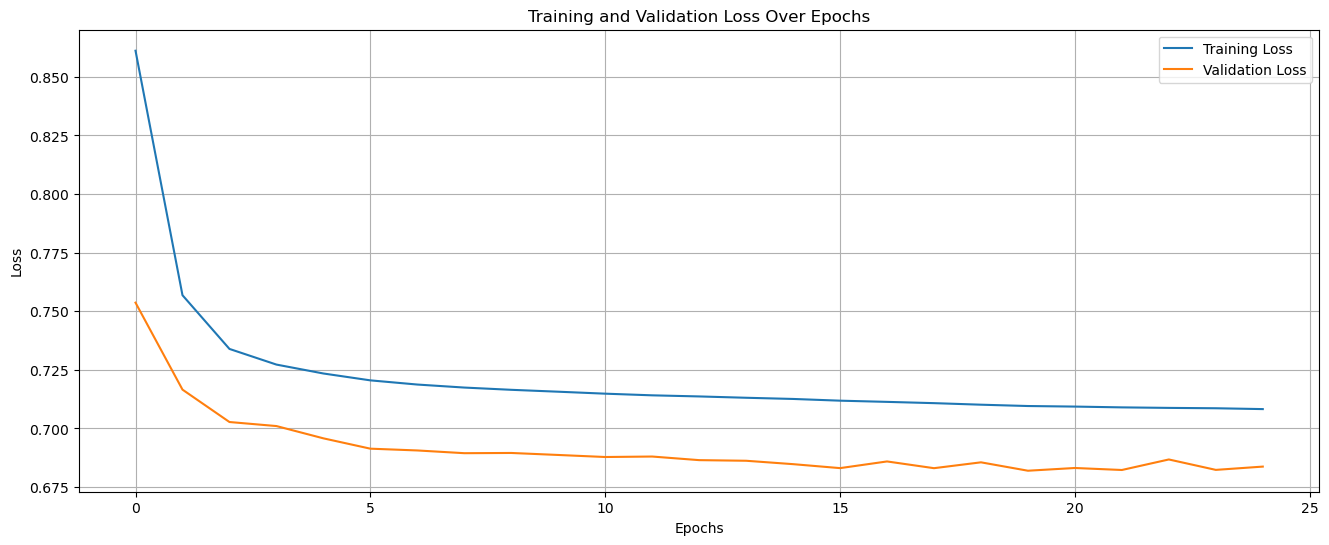

In [19]:
# Extract loss values from the training history
train_loss = history.history['loss']
val_loss   = history.history['val_loss']

# Plot the training and validation loss
plt.figure(figsize=(16, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss,   label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

#### Evaluate the reconstruction loss

- compare the recons loss of normal vs the fraud data

In [20]:
reconstructions_normal = ae.predict(X_normal)

8885/8885 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


In [21]:
reconstructions_normal.shape

(284315, 30)

In [22]:
reconstructions_normal

array([[0.        , 0.        , 0.14013234, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.163794  , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.122738  ],
       ...,
       [0.95959675, 1.988463  , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.4314434 , ..., 0.        , 0.        ,
        0.        ],
       [0.2395016 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.02091145]], dtype=float32)

In [23]:
reconstructions_loss_normal = np.mean(np.square(reconstructions_normal - X_normal), axis=1)

In [24]:
reconstructions_loss_normal                     # dist 1

0          0.298672
1          0.200313
2          0.950305
3          0.612942
4          0.379339
            ...    
284802    11.610416
284803     0.455609
284804     0.465888
284805     0.686782
284806     0.284724
Length: 284315, dtype: float64

In [25]:
reconstructions_fruad = ae.predict(X_fraud)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [26]:
reconstructions_fruad

array([[0.0000000e+00, 0.0000000e+00, 2.7521565e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.6339737e-01, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 4.9294345e-02],
       [0.0000000e+00, 0.0000000e+00, 1.3477862e+00, ..., 0.0000000e+00,
        0.0000000e+00, 9.6331641e-02],
       ...,
       [0.0000000e+00, 0.0000000e+00, 5.3876282e+01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 5.3422291e+01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 5.4039799e+01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [27]:
reconstructions_loss_fraud = np.mean(np.square(reconstructions_fruad - X_fraud), axis=1)

In [28]:
reconstructions_loss_fraud             # dist 2

541           3.380816
623           1.575475
4920         13.948985
6108         44.594828
6329         35.282337
              ...     
279863    15956.327588
280143    15996.245719
280149    15993.167009
281144    16119.456704
281674    16185.576113
Length: 492, dtype: float64

#### Ways to analyze the distributions

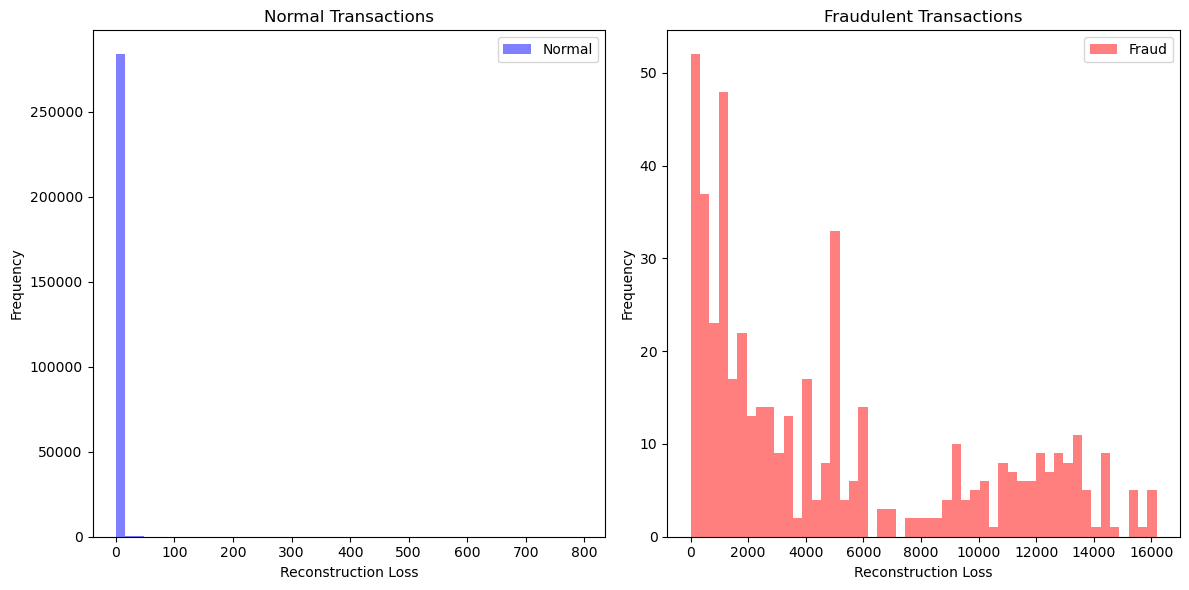

In [29]:
# Plot histograms in two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histogram for normal transaction reconstruction loss
axes[0].hist(reconstructions_loss_normal, bins=50, alpha=0.5, color="blue", label="Normal")
axes[0].set_title("Normal Transactions")
axes[0].set_xlabel("Reconstruction Loss")
axes[0].set_ylabel("Frequency")
axes[0].legend()

# Histogram for fraudulent transaction reconstruction loss
axes[1].hist(reconstructions_loss_fraud, bins=50, alpha=0.5, color="red", label="Fraud")
axes[1].set_title("Fraudulent Transactions")
axes[1].set_xlabel("Reconstruction Loss")
axes[1].set_ylabel("Frequency")
axes[1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

#### mean and std dev

In [30]:
# Calculate mean and standard deviation for normal transactions
mean_normal = np.mean(reconstructions_loss_normal)
std_normal = np.std(reconstructions_loss_normal)

# Calculate mean and standard deviation for fraudulent transactions
mean_fraud = np.mean(reconstructions_loss_fraud)
std_fraud = np.std(reconstructions_loss_fraud)

# Display the results
print("Reconstruction Loss - Normal Transactions:")
print(f"Mean: {mean_normal:.4f}")
print(f"Standard Deviation: {std_normal:.4f}\n")

print("Reconstruction Loss - Fraudulent Transactions:")
print(f"Mean: {mean_fraud:.4f}")
print(f"Standard Deviation: {std_fraud:.4f}")

Reconstruction Loss - Normal Transactions:
Mean: 0.7067
Standard Deviation: 3.1442

Reconstruction Loss - Fraudulent Transactions:
Mean: 4930.4458
Standard Deviation: 4752.4869


#### box plot

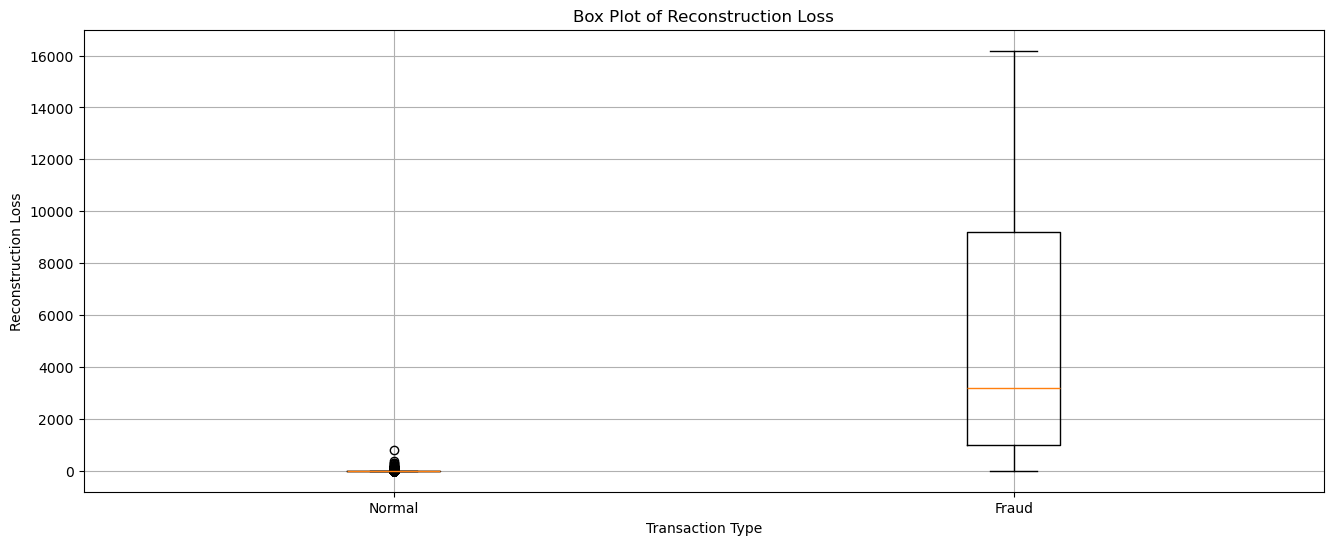

In [31]:
# Combine the reconstruction loss data for normal and fraud into a list
data = [reconstructions_loss_normal, reconstructions_loss_fraud]

# Plot the box plots with updated parameter name
plt.figure(figsize=(16, 6))
plt.boxplot(data, tick_labels=["Normal", "Fraud"], showfliers=True)
plt.title("Box Plot of Reconstruction Loss")
plt.ylabel("Reconstruction Loss")
plt.xlabel("Transaction Type")
plt.grid()
# Show plot
plt.show()

#### KDE (Kernel density estimation)

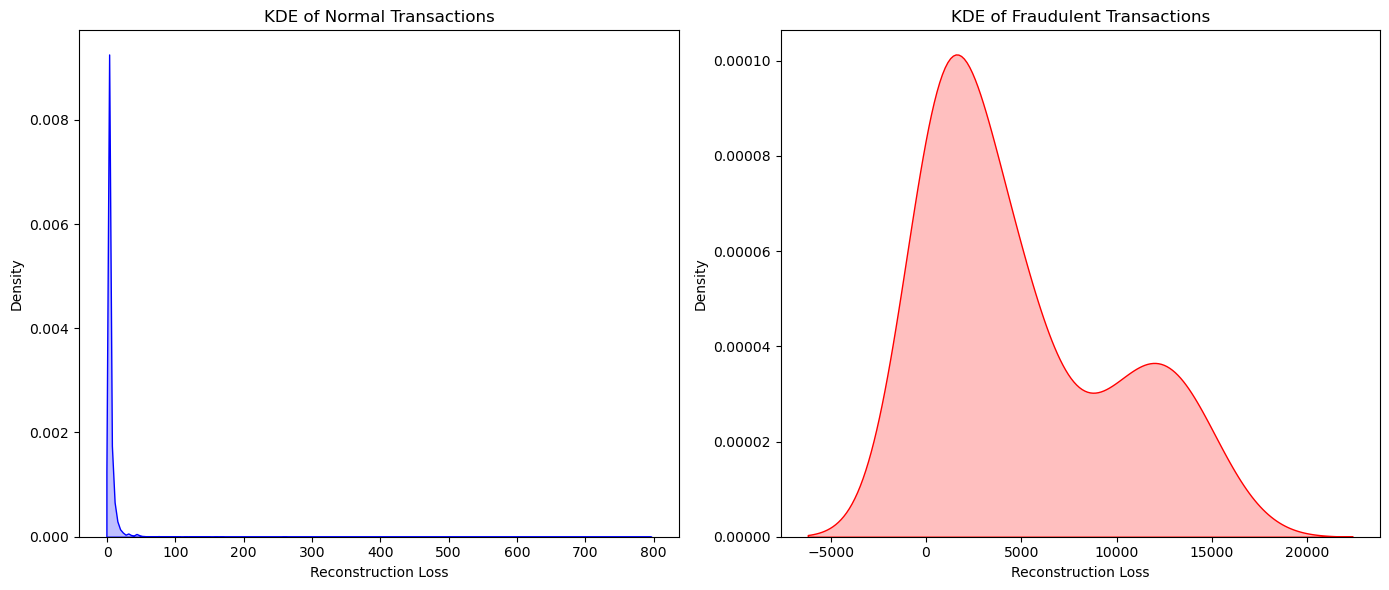

In [32]:
import seaborn as sns

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# KDE plot for normal reconstruction loss
sns.kdeplot(reconstructions_loss_normal, ax=axes[0], color="blue", fill=True, bw_adjust=1.5)
axes[0].set_title("KDE of Normal Transactions")
axes[0].set_xlabel("Reconstruction Loss")
axes[0].set_ylabel("Density")

# KDE plot for fraud reconstruction loss
sns.kdeplot(reconstructions_loss_fraud, ax=axes[1], color="red", fill=True, bw_adjust=1.5)
axes[1].set_title("KDE of Fraudulent Transactions")
axes[1].set_xlabel("Reconstruction Loss")
axes[1].set_ylabel("Density")

# Show the plots
plt.tight_layout()
plt.show()

#### compute the Z-score of fraud vis-avis the normal

In [33]:
# Calculate mean and standard deviation of normal reconstruction losses
mean_normal = np.mean(reconstructions_loss_normal)
std_normal  = np.std(reconstructions_loss_normal)

# Calculate Z-scores for fraudulent reconstruction losses
z_scores_fraud = (reconstructions_loss_fraud - mean_normal) / std_normal

# Display Z-scores
print("Z-Scores of Reconstruction Loss for Fraudulent Transactions:")
print(z_scores_fraud)

Z-Scores of Reconstruction Loss for Fraudulent Transactions:
541          0.850478
623          0.276296
4920         4.211646
6108        13.958447
6329        10.996643
             ...     
279863    5074.628254
280143    5087.324073
280149    5086.344900
281144    5126.510887
281674    5147.539929
Length: 492, dtype: float64


if the loss for fraud and loss for normal are same then what would the Z-scores?

In [34]:
# Count the number of fraud samples with Z-score greater than 3
threshold = 3
count_fraud_outliers = np.sum(z_scores_fraud > threshold)

print(f"Number of fraudulent samples with Z-score greater than {threshold} standard deviations: {count_fraud_outliers}")

Number of fraudulent samples with Z-score greater than 3 standard deviations: 490


#### Quantile comparision

In [35]:
# Assuming reconstruction_loss_normal and reconstruction_loss_fraud are already defined
# Calculate the desired quantiles
quantiles = [0.25, 0.50, 0.75, 0.90]

# Create a DataFrame to hold the results
quantile_comparison = pd.DataFrame({
    'Quantile': quantiles,
    'Normal':   np.quantile(reconstructions_loss_normal, quantiles),
    'Fraud':    np.quantile(reconstructions_loss_fraud, quantiles)
})

# Display the quantile comparison
quantile_comparison

,Quantile,Normal,Fraud
0,0.25,0.248116,1009.809238
1,0.50,0.402638,3179.122121
2,0.75,0.627729,9202.317730
3,0.90,0.986339,12914.698660


#### use the CDF of the 2 dist

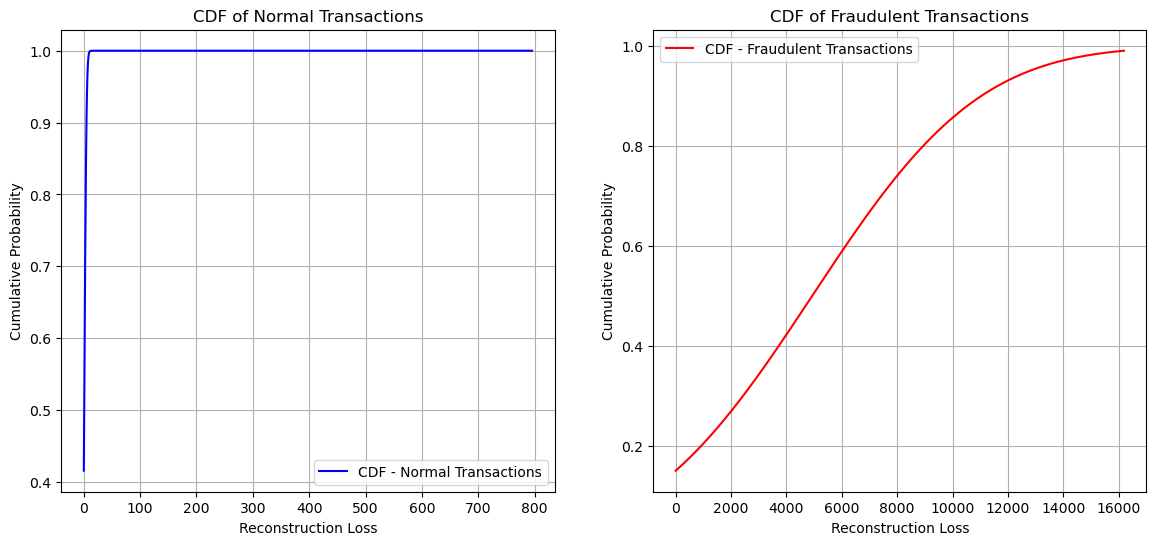

In [36]:
from scipy import stats

# Create a range of values for the CDF
x_normal = np.linspace(min(reconstructions_loss_normal), max(reconstructions_loss_normal), 1000)
x_fraud  = np.linspace(min(reconstructions_loss_fraud),  max(reconstructions_loss_fraud), 1000)

# Calculate the CDF using scipy.stats
cdf_normal = stats.norm.cdf(x_normal, loc=np.mean(reconstructions_loss_normal), scale=np.std(reconstructions_loss_normal))
cdf_fraud  = stats.norm.cdf(x_fraud,  loc=np.mean(reconstructions_loss_fraud),  scale=np.std(reconstructions_loss_fraud))

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot CDF for normal transactions
ax1.plot(x_normal, cdf_normal, label='CDF - Normal Transactions', color='blue')
ax1.set_title('CDF of Normal Transactions')
ax1.set_xlabel('Reconstruction Loss')
ax1.set_ylabel('Cumulative Probability')
ax1.legend()
ax1.grid()

# Plot CDF for fraudulent transactions
ax2.plot(x_fraud, cdf_fraud, label='CDF - Fraudulent Transactions', color='red')
ax2.set_title('CDF of Fraudulent Transactions')
ax2.set_xlabel('Reconstruction Loss')
ax2.set_ylabel('Cumulative Probability')
ax2.legend()
ax2.grid()

#### compare the dist using t-test or equivalent (for not normally dist data)

Normality check...

In [37]:
from scipy.stats import anderson

# Anderson-Darling Test
result_normal = anderson(reconstructions_loss_normal)
result_fraud  = anderson(reconstructions_loss_fraud)

print("Anderson-Darling Test Results for Normal Transactions:")
print(f"Statistic: {result_normal.statistic}, \nCritical Values: {result_normal.critical_values}, \nSignificance Levels: {result_normal.significance_level}")

print("\nAnderson-Darling Test Results for Fraudulent Transactions:")
print(f"Statistic: {result_fraud.statistic}, \nCritical Values: {result_fraud.critical_values}, \nSignificance Levels: {result_fraud.significance_level}")

Anderson-Darling Test Results for Normal Transactions:
Statistic: 80135.04463486758, 
Critical Values: [0.576 0.656 0.787 0.918 1.092], 
Significance Levels: [15.  10.   5.   2.5  1. ]

Anderson-Darling Test Results for Fraudulent Transactions:
Statistic: 27.056886220831984, 
Critical Values: [0.571 0.651 0.781 0.911 1.083], 
Significance Levels: [15.  10.   5.   2.5  1. ]


In [38]:
Q-Q plot 

SyntaxError: invalid syntax (1994000870.py, line 1)

In [ ]:
import statsmodels.api as sm

# Q-Q plot for Normal Transactions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sm.qqplot(reconstructions_loss_normal, line='s', ax=plt.gca())
plt.title('Q-Q Plot for Normal Transactions')

# Q-Q plot for Fraudulent Transactions
plt.subplot(1, 2, 2)
sm.qqplot(reconstructions_loss_fraud, line='s', ax=plt.gca())
plt.title('Q-Q Plot for Fraudulent Transactions')

plt.show()

We cannot use t-test 

but we can non-parameteric alternative (MANN-WHITNEY U TEST)

In [39]:
from scipy.stats import mannwhitneyu

# Mann-Whitney U Test
stat, p_value = mannwhitneyu(reconstructions_loss_normal, reconstructions_loss_fraud)

print(f"Mann-Whitney U Test Statistic: {stat}, p-value: {p_value}")

Mann-Whitney U Test Statistic: 24043.0, p-value: 0.0


Using KL divergence or JSD 
(used in VAE......RBM ... BM ... DALLE ....)

#### KL - devergence

- KL divergence measures how one `probability` distribution diverges from a second expected probability distribution.
- It is not symmetric and can only be used when the reference distribution has a non-zero probability for every point.

- Implementation Steps:
    - First, you need to create probability distributions from the reconstruction loss data (typically using histograms or kernel density estimates).
    - Then, compute the KL divergence between the two distributions.

In [41]:
from scipy.stats import gaussian_kde

# Create kernel density estimates for both distributions
kde_normal = gaussian_kde(reconstructions_loss_normal)
kde_fraud  = gaussian_kde(reconstructions_loss_fraud)

In [42]:
# Create a range of values for the x-axis
x_values = np.linspace(min(reconstructions_loss_normal.min(), reconstructions_loss_fraud.min()),
                       max(reconstructions_loss_normal.max(), reconstructions_loss_fraud.max()), 1000)

In [43]:
# Calculate the probability density functions
pdf_normal = kde_normal(x_values)
pdf_fraud  = kde_fraud(x_values)

In [44]:
# Compute KL divergence
kl_divergence_normal_to_fraud = np.sum(pdf_normal * np.log(pdf_normal / pdf_fraud))
kl_divergence_fraud_to_normal = np.sum(pdf_fraud  * np.log(pdf_fraud / pdf_normal))

print(f"KL Divergence (Normal to Fraud): {kl_divergence_normal_to_fraud}")
print(f"KL Divergence (Fraud to Normal): {kl_divergence_fraud_to_normal}")

KL Divergence (Normal to Fraud): nan
KL Divergence (Fraud to Normal): inf


C:\Users\bhupe\AppData\Local\Temp\ipykernel_10160\2336632187.py:2: RuntimeWarning: divide by zero encountered in log
  kl_divergence_normal_to_fraud = np.sum(pdf_normal * np.log(pdf_normal / pdf_fraud))
C:\Users\bhupe\AppData\Local\Temp\ipykernel_10160\2336632187.py:2: RuntimeWarning: invalid value encountered in multiply
  kl_divergence_normal_to_fraud = np.sum(pdf_normal * np.log(pdf_normal / pdf_fraud))
C:\Users\bhupe\AppData\Local\Temp\ipykernel_10160\2336632187.py:3: RuntimeWarning: divide by zero encountered in divide
  kl_divergence_fraud_to_normal = np.sum(pdf_fraud  * np.log(pdf_fraud / pdf_normal))


In [46]:
# Compute KDE for both distributions
kde_normal = gaussian_kde(reconstructions_loss_normal)
kde_fraud  = gaussian_kde(reconstructions_loss_fraud)

# Define the range for evaluation
x = np.linspace(0, max(max(reconstructions_loss_normal), max(reconstructions_loss_fraud)), 1000)

# Evaluate KDE
kde_normal_values = kde_normal(x)
kde_fraud_values = kde_fraud(x)

# Ensure non-zero values for KL Divergence computation
kde_normal_values += 1e-10  # Small constant to avoid zero values
kde_fraud_values  += 1e-10  # Small constant to avoid zero values

# Compute KL Divergence (normal to fraud)
kl_divergence_normal_to_fraud = np.sum(kde_normal_values * np.log(kde_normal_values / kde_fraud_values))
print(f"KL Divergence (Normal to Fraud): {kl_divergence_normal_to_fraud}")

# Compute KL Divergence (fraud to normal)
kl_divergence_fraud_to_normal = np.sum(kde_fraud_values * np.log(kde_fraud_values / kde_normal_values))
print(f"KL Divergence (Fraud to Normal): {kl_divergence_fraud_to_normal}")

KL Divergence (Normal to Fraud): 4.695456949516063
KL Divergence (Fraud to Normal): 0.7001504485309945


In [52]:
np.linspace( start = 1, stop = 100,  num=30, endpoint=True,  retstep=False)

array([  1.        ,   4.4137931 ,   7.82758621,  11.24137931,
        14.65517241,  18.06896552,  21.48275862,  24.89655172,
        28.31034483,  31.72413793,  35.13793103,  38.55172414,
        41.96551724,  45.37931034,  48.79310345,  52.20689655,
        55.62068966,  59.03448276,  62.44827586,  65.86206897,
        69.27586207,  72.68965517,  76.10344828,  79.51724138,
        82.93103448,  86.34482759,  89.75862069,  93.17241379,
        96.5862069 , 100.        ])

- **Typical Values for KL Divergence**:
  - **Values Close to Zero**: Indicates the two distributions are very similar (e.g., \( < 0.01 \)).
  - **Increasing Values**: 
    - **Low Divergence**: \( 0 - 0.5 \)
    - **Moderate Divergence**: \( 0.5 - 1.5 \)
    - **High Divergence**: \( > 1.5 \)

- **Directionality of KL Divergence**:
  - **Asymmetry**: KL Divergence is not symmetric, meaning $ D_{KL}(P \| Q) \neq D_{KL}(Q \| P) $.
  - **Similar Values**: 
    - Low values in both directions suggest similarity, but their specific nature may differ.
    - For example, if both values are around \( 0.1 \), it indicates that distributions \( P \) and \( Q \) are similar in both directions.

- **Summary**:
  - **Typical KL Divergence Values for Similar Distributions**: Near zero (e.g., \( < 0.01 \)).
  - **Directionality**: Both KL Divergence values can be low and similar for similar distributions, but they are generally not equal.

- **Practical Consideration**:
  - Consider both directions of divergence for a complete picture of the relationship between distributions.
  - Use symmetric measures like Jensen-Shannon Divergence (JSD) for a balanced assessment of similarity. JSD is bounded between 0 and 1, making it easier to interpret.


In [53]:
# Define the distributions
P = np.array([0.1, 0.2, 0.4, 0.1, 0.1, 0.1])  # Actual outcomes
Q = np.array([1/6] * 6)                       # Expected uniform distribution

In [54]:
Q

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667])

In [55]:
# Calculate KL Divergence
kl_divergence = np.sum(P * np.log(P / Q))

print("KL Divergence from P to Q:", kl_divergence)

KL Divergence from P to Q: 0.18232155679395473


In [56]:
# Calculate KL Divergence
kl_divergence = np.sum(Q * np.log(Q / P))

print("KL Divergence from Q to P:", kl_divergence)

KL Divergence from Q to P: 0.1642520334860179


In [57]:
# Define the two probability distributions P and Q
P = np.array([0.3, 0.4, 0.2, 0.1])  # Actual distribution
Q = np.array([0.25, 0.45, 0.2, 0.1])  # Slightly different expected distribution

In [58]:
# Function to calculate KL Divergence
def kl_divergence(P, Q):
    # Avoid division by zero and log of zero by adding a small value
    epsilon = 1e-10
    P = P + epsilon
    Q = Q + epsilon
    kl = np.sum(P * np.log(P / Q))
    return kl

In [59]:
# Compute KL Divergence from P to Q
kl_divergence_P_to_Q = kl_divergence(P, Q)

# Compute KL Divergence from Q to P
kl_divergence_Q_to_P = kl_divergence(Q, P)

print(f"KL Divergence (P to Q): {kl_divergence_P_to_Q}")
print(f"KL Divergence (Q to P): {kl_divergence_Q_to_P}")

KL Divergence (P to Q): 0.0075832527731979835
KL Divergence (Q to P): 0.007421976844596674


#### JSD

In [61]:
kde_normal = gaussian_kde(reconstructions_loss_normal)
kde_fraud  = gaussian_kde(reconstructions_loss_fraud)

In [63]:
# Define the range for evaluation
x = np.linspace(0, max(max(reconstructions_loss_normal), max(reconstructions_loss_fraud)), 1000)


In [64]:
pdf_normal = kde_normal(x)
pdf_fraud  = kde_fraud(x)

In [65]:
pdf_normal /= np.sum(pdf_normal)
pdf_fraud  /= np.sum(pdf_fraud)

In [66]:
average_pdf = 0.5 * (pdf_normal + pdf_fraud)

In [67]:
def kl_divergence(P, Q):
    # Avoid division by zero and log of zero by adding a small value
    epsilon = 1e-10
    P = P + epsilon
    Q = Q + epsilon
    return np.sum(P * np.log(P / Q))

In [68]:
kl_normal_to_average = kl_divergence(pdf_normal, average_pdf)
kl_fraud_to_average  = kl_divergence(pdf_fraud, average_pdf)

In [69]:
jsd = 0.5 * (kl_normal_to_average + kl_fraud_to_average)

print(f"Jensen-Shannon Divergence (JSD): {jsd}")

Jensen-Shannon Divergence (JSD): 0.6853817745454782
